This Experiment notebok is for using the best performing baseline model (in terms of F1-score) and the main model with different values of sub-patch to patch level threshold. We plot graphs by varying the threshold between [0,1], which are used in the Manuscript

Structure:
- Modeling k-means
- Modeling 3D_AE_B10 with temporal encodings
- Plots for the manuscript

## Imports

In [ ]:
%load_ext autoreload
%autoreload 2
import os, sys
from pathlib import Path

os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
sys.path.append('/home/k64835/Master-Thesis-SITS')  #change according to sysem path

scripts_path = Path("../Data-Preprocessing/").resolve()
sys.path.append(str(scripts_path))
scripts_path = Path("../Evaluation/").resolve()
sys.path.append(str(scripts_path))
scripts_path = Path("../Modeling/").resolve()
sys.path.append(str(scripts_path))

In [ ]:
import pickle
import time
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestCentroid
from scripts.data_visualiser import *
from sklearn.manifold import TSNE 
from model_scripts.feature_extraction import *
import torch.nn.functional as F
from Experimentation.expt_scripts.sugarcontent_data_processing import *
from Experimentation.expt_scripts.expt_plots import *
from sklearn.model_selection import train_test_split
from model_scripts.subpatch_extraction import *
from Experimentation.expt_scripts.regression import *
from scripts.data_loader import *
from scripts.data_preprocessor import *
from scripts.temporal_data_preprocessor import *
from scripts.temporal_data_loader import *
from scripts.temporal_visualiser import *
from scripts.temporal_chanel_refinement import *
from model_scripts.model_helper import *
from model_scripts.dataset_creation import *
from model_scripts.train_model_ae import *
from model_scripts.model_visualiser import *
from model_scripts.clustering import *
from evaluation_scripts.evaluation_helper import *
from evaluation_scripts.result_visualiser import *
from Pipeline.temporal_preprocessing_pipeline import *
from evaluation_scripts.result_visualiser import *
from Pipeline.temporal_preprocessing_pipeline import *
from Pipeline.preprocess_script import get_model_ready_data
import numpy as np
import config as config
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import skimage.measure
import torch
import torch.nn as nn
import torch.optim as optim

## Modeling: K-means flattened Images

Load Data: Extracted and Pre-processed subatches 
Dimensions: (N, T, C, H, W) = (N, 7, 10, 4, 4)

In [ ]:
train_subpatches, eval_subpatches, train_coord_fn, eval_coord_fn = get_model_ready_data(model_type='baseline', tensor_type='b10', encoding_method='sin-cos', visualisation_images=False)

Load saved model and apply it to the dataset

In [8]:
with open(config.kmeans_b10_path, 'rb') as file:
    kmeans = pickle.load(file)

eval_subpatch_predictions = kmeans.predict(eval_subpatches.reshape(eval_subpatches.size(0), -1).numpy())

/home/k64835/Master-Thesis-SITS/.venv/lib/python3.12/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator KMeans from version 1.3.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Clustering Accuracy: Convert sub-patch level labels to patch-level labels and compare with ground truth

In [9]:
thresholds = [round(x, 2) for x in np.arange(0.0, 1.1, 0.1)]
accuracies_kmeans = []
recalls_kmeans = []
precisions_kmeans = []
f1_score_kmeans = []

for t in thresholds:
    disease, acc, precision, recall, f1_score, f2_score = evaluate_clustering_metrics(eval_coord_fn, eval_subpatch_predictions, config.labels_path, t)
    accuracies_kmeans.append(acc)
    recalls_kmeans.append(recall)
    precisions_kmeans.append(precision)
    f1_score_kmeans.append(f1_score)
    

## Modeling: Conv3D Autoencoder with Temporal Encodings

### Dataset Prep: B10

Data: Extracted and Pre-processed subpatches 
Dimensions: (N, T, C, H, W) = (N, 7, 10, 4, 4)

In [ ]:
dataloader_train, dataloader_test, dataloader_eval = get_model_ready_data(model_type='autoencoders_addition', tensor_type='b10_add', encoding_method='sin-cos', visualisation_images=False)

### Model prep: Load saved model
Redefine the architecture because the object needs to be created to load saved checkpoints

In [15]:
class Conv3DAutoencoder(nn.Module):
    def __init__(self, in_channels, time_steps, latent_size, patch_size):
        super(Conv3DAutoencoder, self).__init__()

        self.time_steps = time_steps
        self.in_channels = in_channels
        self.patch_size = patch_size

        # --- Encoder (3D Convolutions) ---
        self.conv1 = nn.Conv3d(in_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv3d(128, 256, kernel_size=3, stride=1, padding=1)

        # --- Fully Connected Latent Space ---
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * patch_size * patch_size * time_steps, 512)   
        self.fc2 = nn.Linear(512, latent_size)

        # --- Decoder (Fully Connected) ---
        self.fc3 = nn.Linear(latent_size, 512)
        self.fc4 = nn.Linear(512, 256 * patch_size * patch_size * time_steps)

        # --- 3D Deconvolutions (Transpose convolutions) ---
        self.unflatten = nn.Unflatten(1, (256, time_steps, patch_size, patch_size))
        self.deconv1 = nn.ConvTranspose3d(256, 128, kernel_size=3, stride=1, padding=1)
        self.deconv2 = nn.ConvTranspose3d(128, 64, kernel_size=3, stride=1, padding=1)
        self.deconv3 = nn.ConvTranspose3d(64, in_channels, kernel_size=3, stride=1, padding=1)

        # --- Temporal embedding projection to match channels (needed for alignment) ---
        self.temb_proj = nn.Conv3d(2, in_channels, kernel_size=1)


    def forward(self, x, date_embeddings):

        # --- Date embedding processing ---
        # Convert the date embeddings to the shape (B, 2, 7, 4, 4)
        if not isinstance(date_embeddings, torch.Tensor):
            date_embeddings_tensor = torch.tensor(date_embeddings, dtype=torch.float32).to(x.device)    # Shape: (B, 7, 2)
        date_embeddings_tensor = date_embeddings_tensor.permute(0, 2, 1)                                # Shape: (B, 2, 7)
        date_embeddings_tensor = date_embeddings_tensor.unsqueeze(-1).unsqueeze(-1)                     # Shape: (B, 2, 7, 1, 1)
        date_embeddings_tensor = date_embeddings_tensor.expand(-1, -1, -1, x.shape[3], x.shape[4])      # Shape: (B, 2, 7, 4, 4)

        # Project the date embeddings to match the channels
        date_embeddings_tensor = self.temb_proj(date_embeddings_tensor)                                 # Shape: (B, 10, 7, 4, 4)
        # print('x shape before time embedding:',x.shape)
        # print('time embeddings:',date_embeddings_tensor.shape)
        
        # --- Add date embeddings to the input tensor ---
        x = x + date_embeddings_tensor                                                                  # Shape: (B, 10, 7, 4, 4)
        # print('x shape after time embedding',x.shape)
        
        # --- Encoder ---
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # --- Flatten and Fully Connected ---
        b, c, t, h, w = x.shape                 # (B, C, T, H, W)
        x = self.flatten(x)  
        x = F.relu(self.fc1(x))
        z = self.fc2(x)                         # Bottleneck    

        # --- Decoder ---
        x = F.relu(self.fc3(z))
        x = F.relu(self.fc4(x))

        # --- Reshape and 3D Deconvolutions ---
        x = self.unflatten(x)                   # (B, C, H, W, T)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x_reconstructed = self.deconv3(x)       # Reconstruction

        return z, x_reconstructed

In [16]:
latent_dim=32
in_channels = 12
time_steps = 7
device = 'cuda'
model = Conv3DAutoencoder(in_channels, time_steps, latent_dim, config.subpatch_size)

with open(config.ae_3d_TEadd_path, 'rb') as file:
    trained_model = pickle.load(file)

with open(config.kmeans_ae_3D_TEadd_path, 'rb') as file:
    kmeans = pickle.load(file)

/home/k64835/Master-Thesis-SITS/.venv/lib/python3.12/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator KMeans from version 1.3.2 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


### Extract Features/Latents and Evaluate

In [17]:
eval_features, eval_coord_dl = extract_features_ae(trained_model, dataloader_eval, temp_embed_pixel=True, device=device)
eval_features = eval_features.cpu()
eval_subpatch_predictions = kmeans.predict(eval_features.reshape(eval_features.size(0), -1).numpy().astype(np.float32))

Clustering Accuracy: Convert sub-patch level labels to patch-level labels and compare with ground truth

In [18]:
thresholds = [round(x, 2) for x in np.arange(0.0, 1.1, 0.1)]
accuracies_3d = []
recalls_3d = []
precision_3d = []
f1_score_3d = []

for t in thresholds:
    disease, acc, precision, recall, f1_score, f2_score = evaluate_clustering_metrics(eval_coord_dataloader, eval_subpatch_predictions, config.labels_path, t)
    accuracies_3d.append(acc)
    recalls_3d.append(recall)
    precision_3d.append(precision)
    f1_score_3d.append(f1_score)

## Plot: PR-Curve

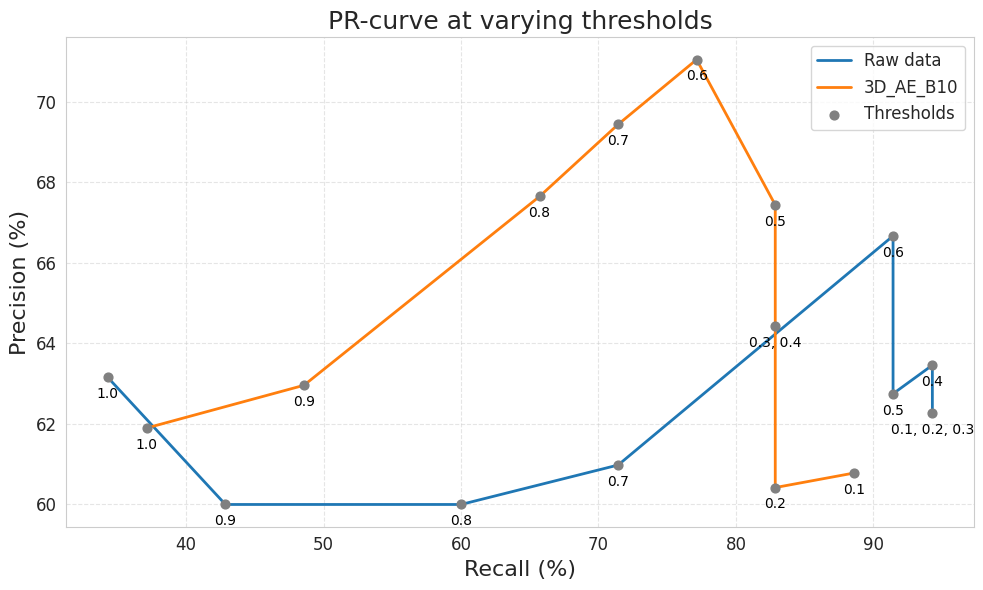

In [ ]:
accuracies_dict = {
    'Raw data': accuracies_kmeans,
    '3D_AE_B10': accuracies_3d
}

recalls_dict = {
    'Raw data': recalls_kmeans,
    '3D_AE_B10': recalls_3d
}

precisions_dict = {
    'Raw data': precisions_kmeans,
    '3D_AE_B10': precision_3d
}

f1_dict = {
    'Raw data': f1_score_kmeans,
    '3D_AE_B10': f1_score_3d
}

plot_acc_vs_recall_for_paper(thresholds, precisions_dict, recalls_dict, title='PR-curve at varying thresholds')

## Plot: F1-score curve

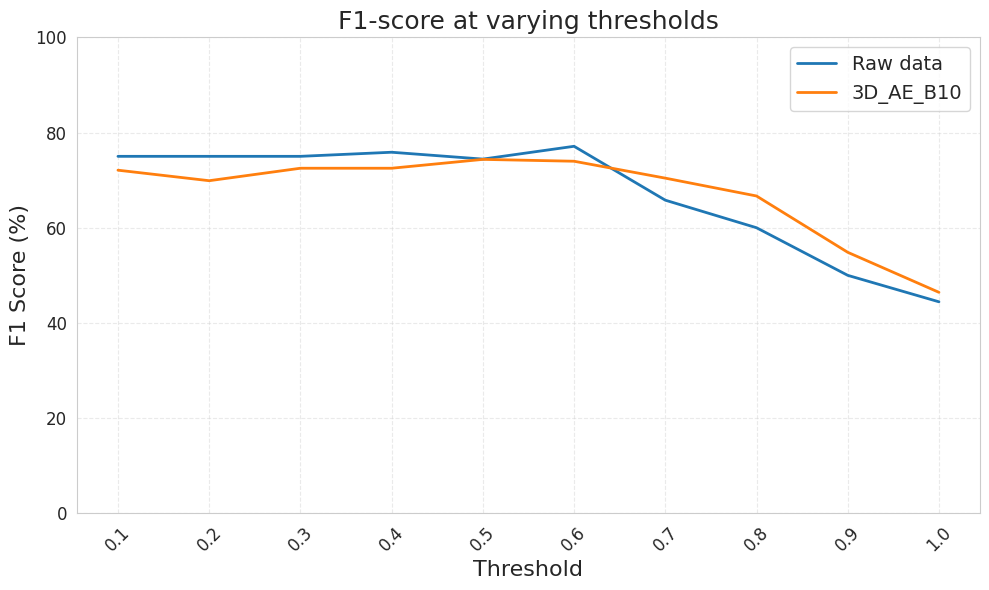

In [24]:
plot_f1_scores_vs_thresholds(thresholds, f1_dict)